In [1]:
import cartopy.crs as ccrs
import xarray as xr
import xesmf as xe
import os
import matplotlib.pyplot as plt
import pyproj
import numpy as np
from osgeo import gdal
import rioxarray as rxr
import netCDF4

## Method 1. Loading HDF (modis data) using rioxarray package

In [ ]:
# # testing: load HDF with xarray
# FILE_NAME = '/Users/josephko/USC/Research/Remote Sensing/modis_files/MCD43A3.A2014358.h08v05.006.2016155120959.hdf'
# modis_ds = xr.open_dataset(FILE_NAME)
# modis_ds
# # results in error because not supported
# # need to use rioxarray to load HDF4 (or HDF-EOS)

In [2]:
# testing: load HDF with rioxarray
FILE_NAME = '/Users/josephko/USC/Research/Remote Sensing/modis_files/MCD43A3.A2014358.h08v05.006.2016155120959.hdf'
modis_ds = rxr.open_rasterio(FILE_NAME, masked=True)
#bsa_shortwave = modis_ds['Albedo_BSA_shortwave'] if you need to select one of the features
modis_ds_transform = modis_ds.rio.transform()
print(modis_ds_transform)
print(modis_ds_transform[4])
print(modis_ds.dims['x'])
print(modis_ds.dims['y'])

| 463.31, 0.00,-11119505.20|
| 0.00,-463.31, 4447802.08|
| 0.00, 0.00, 1.00|
-463.3127165279167
2400
2400


In [3]:
# save transform parameters
x0 = modis_ds_transform[2]
xinc = modis_ds_transform[0]
y0 = modis_ds_transform[5]
yinc = modis_ds_transform[4]
nx, ny = (modis_ds.dims['x'], modis_ds.dims['y'])
x = np.linspace(x0, x0 + xinc*nx, nx)
y = np.linspace(y0, y0 + yinc*ny, ny)
xv, yv = np.meshgrid(x, y)
# get lat/lon
sinu = '+proj=sinu +R=6371007.181 +nadgrids=@null +wktext'
wgs84 = 'EPSG:4326' 
t = pyproj.Transformer.from_crs(sinu, wgs84, always_xy=True)
lon, lat = t.transform(xv, yv)
print('xv shape: ', xv.shape)
print('yv shape: ', yv.shape)
print('lon shape: ', lon.shape)
print('lat shape: ', lat.shape)
modis_ds

xv shape:  (2400, 2400)
yv shape:  (2400, 2400)
lon shape:  (2400, 2400)
lat shape:  (2400, 2400)


<xarray.Dataset>
Dimensions:                                       (y: 2400, x: 2400, band: 1)
Coordinates:
  * y                                             (y) float64 4.448e+06 ... 3...
  * x                                             (x) float64 -1.112e+07 ... ...
  * band                                          (band) int64 1
    spatial_ref                                   int64 0
Data variables: (12/30)
    BRDF_Albedo_Band_Mandatory_Quality_Band1      (band, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_shortwave  (band, y, x) float32 ...
    Albedo_BSA_Band1                              (band, y, x) float32 ...
    Albedo_BSA_Band2                              (band, y, x) float32 ...
    Albedo_BSA_Band3                              (band, y, x) float32 ...
    Albedo_BSA_Band4                              (band, y, x) float32 ...
    ...                                            ...
    BRDF_Albedo_Band_Mandatory_Quality_Band4      (band, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band5      (band, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band6      (band, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_Band7      (band, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_vis        (band, y, x) float32 ...
    BRDF_Albedo_Band_Mandatory_Quality_nir        (band, y, x) float32 ...
Attributes: (12/70)
    ALBEDOFILEID:                       6121997
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDINSTRUMENTSHORTNAME.2:    MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:      Terra
    ASSOCIATEDPLATFORMSHORTNAME.2:      Aqua
    ASSOCIATEDSENSORSHORTNAME.1:        MODIS
    ...                                 ...
    SOUTHBOUNDINGCOORDINATE:            29.9999999973059
    SPSOPARAMETERS:                     2015
    TileID:                             51008005
    VERSIONID:                          6
    VERTICALTILENUMBER:                 5
    WESTBOUNDINGCOORDINATE:             -130.540728914638

In [13]:
# plot (x, y) coordinates
#plt.scatter(modis_ds['x'], modis_ds['y'], s=0.01)
x_values = modis_ds['x'].values
y_values = modis_ds['y'].values
print(x_values[0:5])
print(x_values[1] - x_values[0])
print(x_values[2] - x_values[1])
print(x_values[3] - x_values[2])
print(y_values[0:5])

[-11119273.54030874 -11118810.22759221 -11118346.91487568
 -11117883.60215915 -11117420.28944262]
463.3127165287733
463.31271652691066
463.3127165287733
[4447570.42230874 4447107.10959221 4446643.79687568 4446180.48415915
 4445717.17144262]


In [41]:
print('lon: ', lon[:10])
print('lat: ', lat[:10])

lon:  [[-130.54072891 -130.53528745 -130.52984599 ... -117.49753895
  -117.49209749 -117.48665602]
 [-130.53276069 -130.52731956 -130.52187843 ... -117.49036689
  -117.48492576 -117.47948462]
 [-130.52479414 -130.51935334 -130.51391254 ... -117.48319632
  -117.47775552 -117.47231472]
 ...
 [-130.48498629 -130.47954715 -130.47410801 ... -117.44736594
  -117.4419268  -117.43648766]
 [-130.47702971 -130.4715909  -130.46615209 ... -117.44020435
  -117.43476555 -117.42932674]
 [-130.46907478 -130.46363631 -130.45819783 ... -117.43304426
  -117.42760578 -117.42216731]]
lat:  [[40.         40.         40.         ... 40.         40.
  40.        ]
 [39.99583159 39.99583159 39.99583159 ... 39.99583159 39.99583159
  39.99583159]
 [39.99166319 39.99166319 39.99166319 ... 39.99166319 39.99166319
  39.99166319]
 ...
 [39.97082117 39.97082117 39.97082117 ... 39.97082117 39.97082117
  39.97082117]
 [39.96665277 39.96665277 39.96665277 ... 39.96665277 39.96665277
  39.96665277]
 [39.96248436 39.96248

In [42]:
# add lat/lon to modis_ds
modis_ds = modis_ds.assign_coords({'lon': (['y', 'x'], lon),
                       'lat': (['y', 'x'], lat)})
modis_ds = modis_ds*0.001
modis_ds

<xarray.Dataset>
Dimensions:                                       (y: 2400, x: 2400, band: 1)
Coordinates:
  * y                                             (y) float64 4.448e+06 ... 3...
  * x                                             (x) float64 -1.112e+07 ... ...
  * band                                          (band) int64 1
    spatial_ref                                   int64 0
    lon                                           (y, x) float64 -130.5 ... -...
    lat                                           (y, x) float64 40.0 ... 30.0
Data variables: (12/30)
    BRDF_Albedo_Band_Mandatory_Quality_Band1      (band, y, x) float32 nan .....
    BRDF_Albedo_Band_Mandatory_Quality_shortwave  (band, y, x) float32 nan .....
    Albedo_BSA_Band1                              (band, y, x) float32 nan .....
    Albedo_BSA_Band2                              (band, y, x) float32 nan .....
    Albedo_BSA_Band3                              (band, y, x) float32 nan .....
    Albedo_BSA_Band4                              (band, y, x) float32 nan .....
    ...                                            ...
    BRDF_Albedo_Band_Mandatory_Quality_Band4      (band, y, x) float32 nan .....
    BRDF_Albedo_Band_Mandatory_Quality_Band5      (band, y, x) float32 nan .....
    BRDF_Albedo_Band_Mandatory_Quality_Band6      (band, y, x) float32 nan .....
    BRDF_Albedo_Band_Mandatory_Quality_Band7      (band, y, x) float32 nan .....
    BRDF_Albedo_Band_Mandatory_Quality_vis        (band, y, x) float32 nan .....
    BRDF_Albedo_Band_Mandatory_Quality_nir        (band, y, x) float32 nan .....
Attributes: (12/70)
    ALBEDOFILEID:                       6121997
    ASSOCIATEDINSTRUMENTSHORTNAME.1:    MODIS
    ASSOCIATEDINSTRUMENTSHORTNAME.2:    MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:      Terra
    ASSOCIATEDPLATFORMSHORTNAME.2:      Aqua
    ASSOCIATEDSENSORSHORTNAME.1:        MODIS
    ...                                 ...
    SOUTHBOUNDINGCOORDINATE:            29.9999999973059
    SPSOPARAMETERS:                     2015
    TileID:                             51008005
    VERSIONID:                          6
    VERTICALTILENUMBER:                 5
    WESTBOUNDINGCOORDINATE:             -130.540728914638

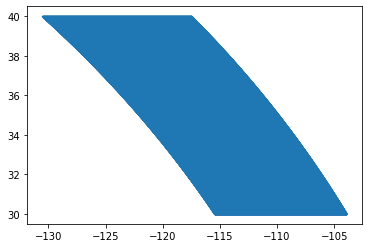

In [43]:
plt.scatter(modis_ds['lon'], modis_ds['lat'], s=0.01)

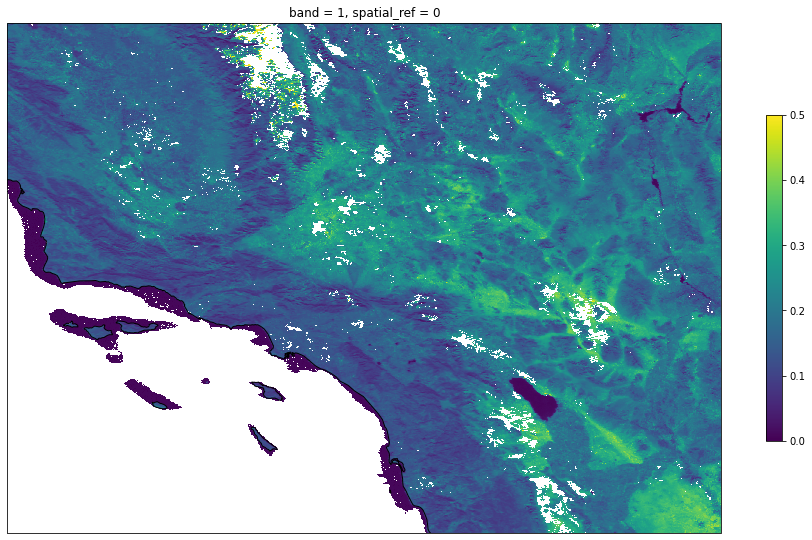

In [44]:
# plot to visualize
plot_data = modis_ds['Albedo_BSA_shortwave']
fig = plt.figure(figsize=(8*2,12*2))
#ax = plt.axes(projection=ccrs.PlateCarree())
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-121, -114, 32, 37], crs=ccrs.PlateCarree())
ax.coastlines()
mesh = plot_data[0].plot.pcolormesh(ax = ax, x='lon' ,y='lat', add_colorbar=False, shading='auto', vmin=0, vmax=0.5)
fig.colorbar(mesh, shrink=0.25)

## Method 2: Loading HDF (modis data) using gdal

In [ ]:
# load HDF file and create array for black sky albedo (bsa)
FILE_NAME = '/Users/josephko/USC/Research/Remote Sensing/modis_files/MCD43A3.A2014358.h08v05.006.2016155120959.hdf'
DATAFIELD_NAME = 'Albedo_BSA_shortwave'
GRID_NAME = 'MOD_Grid_BRDF'    
bsa_gname = 'HDF4_EOS:EOS_GRID:"{0}":{1}:{2}'.format(FILE_NAME, GRID_NAME, DATAFIELD_NAME)
print('gname: ', bsa_gname)
bsa_gdset = gdal.Open(bsa_gname)
bsa_data = bsa_gdset.ReadAsArray().astype(np.float64)
print('Preview BSA data:')
print(bsa_data[1000:1010, 1000:1010])

In [ ]:
# Construct the grid.
x0, xinc, _, y0, _, yinc = bsa_gdset.GetGeoTransform()
nx, ny = (bsa_gdset.RasterXSize, bsa_gdset.RasterYSize)
x = np.linspace(x0, x0 + xinc*nx, nx)
y = np.linspace(y0, y0 + yinc*ny, ny)
xv, yv = np.meshgrid(x, y)

print('Geotransform outputs:')
print('x0 = ', x0, ' xinc = ', xinc, ' y0 = ', y0, ' yinc = ', yinc)
print('Check x and y arrays:')
print('x[:10]',x[:10])
print('y[:10]',y[:10])

In [ ]:
# get lat/lon
sinu = '+proj=sinu +R=6371007.181 +nadgrids=@null +wktext'
wgs84 = 'EPSG:4326' 
t = pyproj.Transformer.from_crs(sinu, wgs84)
lon, lat = t.transform(xv, yv)
print('xv shape: ', xv.shape)
print('yv shape: ', yv.shape)
print('lon shape: ', lon.shape)
print('lat shape: ', lat.shape)

In [ ]:
print(type(lat))
print(type(lat_2))
print(np.setdiff1d(lat, lat_2))

## Load WRF input data

In [8]:
# load WRF sample input file
wrf_file_path = '/Users/josephko/USC/Research/Remote Sensing/wrf_files/wrfinput_d03_aug'
wrf_ds = xr.open_dataset(wrf_file_path)


In [9]:
# rename coordinates to lat/lon
wrf_ds = wrf_ds.rename({'XLAT':'lat', 'XLONG':'lon'})
wrf_ds = wrf_ds.squeeze('Time')
wrf_ds

<xarray.Dataset>
Dimensions:              (south_north: 141, west_east: 129, bottom_top: 29, bottom_top_stag: 30, soil_layers_stag: 4, west_east_stag: 130, south_north_stag: 142, DIM0009: 5, land_cat_stag: 33, soil_cat_stag: 16, urban_wind_directions_stag: 4, num_ext_model_couple_dom_stag: 1)
Coordinates:
    lat                  (south_north, west_east) float32 ...
    lon                  (south_north, west_east) float32 ...
    XLAT_U               (south_north, west_east_stag) float32 ...
    XLONG_U              (south_north, west_east_stag) float32 ...
    XLAT_V               (south_north_stag, west_east) float32 ...
    XLONG_V              (south_north_stag, west_east) float32 ...
Dimensions without coordinates: south_north, west_east, bottom_top, bottom_top_stag, soil_layers_stag, west_east_stag, south_north_stag, DIM0009, land_cat_stag, soil_cat_stag, urban_wind_directions_stag, num_ext_model_couple_dom_stag
Data variables: (12/131)
    Times                |S19 ...
    LU_INDEX             (south_north, west_east) float32 ...
    ZNU                  (bottom_top) float32 ...
    ZNW                  (bottom_top_stag) float32 ...
    ZS                   (soil_layers_stag) float32 ...
    DZS                  (soil_layers_stag) float32 ...
    ...                   ...
    SAVE_TOPO_FROM_REAL  int32 ...
    LAKEFLAG             int32 ...
    LAKE_DEPTH_FLAG      int32 ...
    LANDMASK             (south_north, west_east) float32 ...
    LAKEMASK             (south_north, west_east) float32 ...
    SST                  (south_north, west_east) float32 ...
Attributes: (12/70)
    TITLE:                            OUTPUT FROM REAL_EM V3.6.1 PREPROCESSOR
    START_DATE:                      2012-06-28_21:00:00
    SIMULATION_START_DATE:           2012-06-28_21:00:00
    WEST-EAST_GRID_DIMENSION:        130
    SOUTH-NORTH_GRID_DIMENSION:      142
    BOTTOM-TOP_GRID_DIMENSION:       30
    ...                              ...
    NUM_LAND_CAT:                    33
    ISWATER:                         16
    ISLAKE:                          -1
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14

## Perform Re-gridding 

In [10]:
modis_ds['Albedo_BSA_shortwave']

<xarray.DataArray 'Albedo_BSA_shortwave' (band: 1, y: 2400, x: 2400)>
[5760000 values with dtype=float32]
Coordinates:
  * y            (y) float64 4.448e+06 4.447e+06 ... 3.337e+06 3.336e+06
  * x            (x) float64 -1.112e+07 -1.112e+07 ... -1.001e+07 -1.001e+07
  * band         (band) int64 1
    spatial_ref  int64 0
    lon          (y, x) float64 -130.5 -130.5 -130.5 ... -103.9 -103.9 -103.9
    lat          (y, x) float64 40.0 40.0 40.0 40.0 40.0 ... 30.0 30.0 30.0 30.0
Attributes:
    scale_factor:  0.001
    add_offset:    0.0
    long_name:     Albedo_BSA_shortwave
    units:         reflectance, no units

In [11]:
wrf_ds

<xarray.Dataset>
Dimensions:              (south_north: 141, west_east: 129, bottom_top: 29, bottom_top_stag: 30, soil_layers_stag: 4, west_east_stag: 130, south_north_stag: 142, DIM0009: 5, land_cat_stag: 33, soil_cat_stag: 16, urban_wind_directions_stag: 4, num_ext_model_couple_dom_stag: 1)
Coordinates:
    lat                  (south_north, west_east) float32 32.23 32.23 ... 35.14
    lon                  (south_north, west_east) float32 -119.0 ... -116.8
    XLAT_U               (south_north, west_east_stag) float32 32.22 ... 35.14
    XLONG_U              (south_north, west_east_stag) float32 -119.0 ... -116.8
    XLAT_V               (south_north_stag, west_east) float32 32.22 ... 35.15
    XLONG_V              (south_north_stag, west_east) float32 -119.0 ... -116.8
Dimensions without coordinates: south_north, west_east, bottom_top, bottom_top_stag, soil_layers_stag, west_east_stag, south_north_stag, DIM0009, land_cat_stag, soil_cat_stag, urban_wind_directions_stag, num_ext_model_couple_dom_stag
Data variables: (12/131)
    Times                |S19 b'2012-06-28_21:00:00'
    LU_INDEX             (south_north, west_east) float32 16.0 16.0 ... 8.0 8.0
    ZNU                  (bottom_top) float32 0.9965 0.988 ... 0.02364 0.007539
    ZNW                  (bottom_top_stag) float32 1.0 0.993 ... 0.01508 0.0
    ZS                   (soil_layers_stag) float32 0.05 0.25 0.7 1.5
    DZS                  (soil_layers_stag) float32 0.1 0.3 0.6 1.0
    ...                   ...
    SAVE_TOPO_FROM_REAL  int32 1
    LAKEFLAG             int32 0
    LAKE_DEPTH_FLAG      int32 0
    LANDMASK             (south_north, west_east) float32 0.0 0.0 ... 1.0 1.0
    LAKEMASK             (south_north, west_east) float32 0.0 0.0 ... 0.0 0.0
    SST                  (south_north, west_east) float32 289.1 289.1 ... 326.2
Attributes: (12/70)
    TITLE:                            OUTPUT FROM REAL_EM V3.6.1 PREPROCESSOR
    START_DATE:                      2012-06-28_21:00:00
    SIMULATION_START_DATE:           2012-06-28_21:00:00
    WEST-EAST_GRID_DIMENSION:        130
    SOUTH-NORTH_GRID_DIMENSION:      142
    BOTTOM-TOP_GRID_DIMENSION:       30
    ...                              ...
    NUM_LAND_CAT:                    33
    ISWATER:                         16
    ISLAKE:                          -1
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14

In [16]:
modis_ds['Albedo_BSA_shortwave'].nbytes/1e9

0.02304

In [17]:
# ======================================================================
# Perform re-gridding using xESMF
# ======================================================================
# reference: https://xesmf.readthedocs.io/en/latest/notebooks/Curvilinear_grid.html
regridder = xe.Regridder(modis_ds['Albedo_BSA_shortwave'], wrf_ds, 'bilinear', 
                         filename='modis_to_wrf_regrid_weights.nc')

In [45]:
regridder_reuse = xe.Regridder(modis_ds['Albedo_BSA_shortwave'], wrf_ds,'bilinear', periodic=True, 
                               reuse_weights=True, filename='modis_to_wrf_regrid_weights.nc')

modis_ds_out = regridder_reuse(modis_ds['Albedo_BSA_shortwave'])
modis_ds_out

/Users/josephko/opt/anaconda3/envs/xesmf_env/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


<xarray.DataArray (band: 1, south_north: 141, west_east: 129)>
array([[[0.        , 0.        , 0.        , ..., 0.12385756,
         0.11801337, 0.14012714],
        [0.        , 0.        , 0.        , ..., 0.14892073,
         0.16255103, 0.15994075],
        [0.        , 0.        , 0.        , ..., 0.13717102,
         0.11646853, 0.15696892],
        ...,
        [0.12579818, 0.12706883, 0.09719517, ..., 0.19633214,
         0.21815747, 0.28573865],
        [0.12952186, 0.13836677, 0.1168588 , ..., 0.2205647 ,
         0.22263362, 0.1647662 ],
        [0.13187855, 0.10531199, 0.10380799, ..., 0.21347228,
         0.20093618, 0.17595835]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
    lon          (south_north, west_east) float32 -119.0 -119.0 ... -116.8
    lat          (south_north, west_east) float32 32.23 32.23 ... 35.14 35.14
Dimensions without coordinates: south_north, west_east
Attributes:
    regrid_method:  bilinear

In [46]:
# write regridded data as netcdf file
modis_ds_out.to_netcdf(path = "albedo_regridded_test.nc", mode = 'w', )

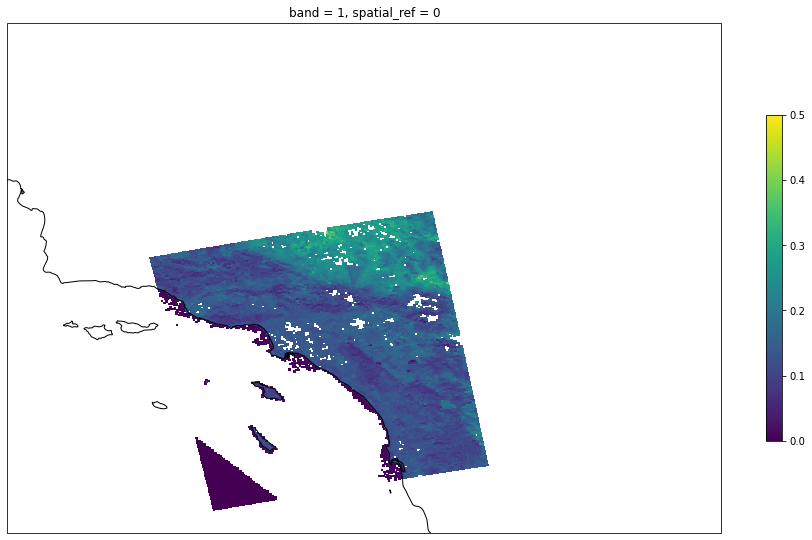

In [48]:
# plot to visualize
plot_data = modis_ds_out
fig = plt.figure(figsize=(8*2,12*2))
#ax = plt.axes(projection=ccrs.PlateCarree())
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-121, -114, 32, 37], crs=ccrs.PlateCarree())
ax.coastlines()
mesh = plot_data[0].plot.pcolormesh(ax = ax, x='lon' ,y='lat', add_colorbar=False, shading='auto', vmin=0, vmax=0.5)
cbar = fig.colorbar(mesh, shrink=0.25)

## Edit wrfinput file with regridded modis data

In [51]:
wrfinput_default_file_path = '/Users/josephko/USC/Research/Remote Sensing/wrf_files/wrfinput_d03_2015run_02.nc'
wrf_default = netCDF4.Dataset(wrfinput_default_file_path,'r')
print(wrf_default['ALBBCK'][:])

[[[0.08       0.08       0.08       ... 0.11458942 0.11612915 0.11784322]
  [0.08       0.08       0.08       ... 0.11628516 0.11828858 0.12045953]
  [0.08       0.08       0.08       ... 0.11781346 0.12027457 0.12290368]
  ...
  [0.08552033 0.08673941 0.08795786 ... 0.19748992 0.19847307 0.19967258]
  [0.08653788 0.08775696 0.08897542 ... 0.19642423 0.19743884 0.19856912]
  [0.08757452 0.0887751  0.08999357 ... 0.19533472 0.19641271 0.19748911]]]


In [53]:
wrfinput_file_path = '/Users/josephko/USC/Research/Remote Sensing/wrf_files/wrfinput_d03_2015run_02_mod.nc'
wrf_input = netCDF4.Dataset(wrfinput_file_path,'r')
print(wrf_input['ALBBCK'][:][wrf_input['ALBBCK'][:] == 0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [60]:
wrfinput_default_file_path = '/Users/josephko/USC/Research/Remote Sensing/wrf_files/wrfinput_d03_2015run_02.nc'
wrfinput_default = xr.open_dataset(wrfinput_default_file_path)
albedo_default = wrfinput_default['ALBBCK']
albedo_default

<xarray.DataArray 'ALBBCK' (Time: 1, south_north: 141, west_east: 129)>
array([[[0.08    , 0.08    , ..., 0.116129, 0.117843],
        [0.08    , 0.08    , ..., 0.118289, 0.12046 ],
        ...,
        [0.086538, 0.087757, ..., 0.197439, 0.198569],
        [0.087575, 0.088775, ..., 0.196413, 0.197489]]], dtype=float32)
Coordinates:
    XLAT     (Time, south_north, west_east) float32 ...
    XLONG    (Time, south_north, west_east) float32 ...
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  BACKGROUND ALBEDO
    units:        
    stagger:      
    coordinates:  XLONG XLAT XTIME

In [67]:
modis_ds_out.where(modis_ds_out!=0)

<xarray.DataArray (band: 1, south_north: 141, west_east: 129)>
array([[[       nan,        nan,        nan, ..., 0.12385756,
         0.11801337, 0.14012714],
        [       nan,        nan,        nan, ..., 0.14892073,
         0.16255103, 0.15994075],
        [       nan,        nan,        nan, ..., 0.13717102,
         0.11646853, 0.15696892],
        ...,
        [0.12579818, 0.12706883, 0.09719517, ..., 0.19633214,
         0.21815747, 0.28573865],
        [0.12952186, 0.13836677, 0.1168588 , ..., 0.2205647 ,
         0.22263362, 0.1647662 ],
        [0.13187855, 0.10531199, 0.10380799, ..., 0.21347228,
         0.20093618, 0.17595835]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
    lon          (south_north, west_east) float32 -119.0 -119.0 ... -116.8
    lat          (south_north, west_east) float32 32.23 32.23 ... 35.14 35.14
Dimensions without coordinates: south_north, west_east
Attributes:
    regrid_method:  bilinear

In [70]:
type(modis_ds_out)
modis_ds_out_mod = modis_ds_out.where(modis_ds_out!=0)
modis_ds_out_mod = modis_ds_out_mod.combine_first(albedo_default)
modis_ds_out_mod

<xarray.DataArray (band: 1, south_north: 141, west_east: 129, Time: 1)>
array([[[[0.08      ],
         [0.08      ],
         [0.08      ],
         ...,
         [0.12385756],
         [0.11801337],
         [0.14012714]],

        [[0.08      ],
         [0.08      ],
         [0.08      ],
         ...,
         [0.14892073],
         [0.16255103],
         [0.15994075]],

        [[0.08      ],
         [0.08      ],
         [0.08      ],
         ...,
...
         ...,
         [0.19633214],
         [0.21815747],
         [0.28573865]],

        [[0.12952186],
         [0.13836677],
         [0.1168588 ],
         ...,
         [0.2205647 ],
         [0.22263362],
         [0.1647662 ]],

        [[0.13187855],
         [0.10531199],
         [0.10380799],
         ...,
         [0.21347228],
         [0.20093618],
         [0.17595835]]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
    lon          (south_north, west_east) float32 -119.0 -119.0 ... -116.8
    lat          (south_north, west_east) float32 32.23 32.23 ... 35.14 35.14
    XLAT         (Time, south_north, west_east) float32 32.23 32.23 ... 35.14
    XLONG        (Time, south_north, west_east) float32 -119.0 -119.0 ... -116.8
Dimensions without coordinates: south_north, west_east, Time
Attributes:
    regrid_method:  bilinear

In [71]:
wrfinput_file_path = '/Users/josephko/USC/Research/Remote Sensing/wrf_files/wrfinput_d03_2015run_02_mod.nc'
wrf_input = netCDF4.Dataset(wrfinput_file_path,'r+')
wrf_input['ALBBCK'][:] = modis_ds_out_mod
wrf_input.close() 



## Regrid GVF and modify wrfinput

In [87]:
modis_ndvi_filepath = '/Users/josephko/USC/Research/Remote Sensing/modis_files/MOD13A3.A2016061.h08v05.006.2016110163108.hdf'

modis_ndvi = rxr.open_rasterio(modis_ndvi_filepath, masked=True)
#bsa_shortwave = modis_ds['Albedo_BSA_shortwave'] if you need to select one of the features
modis_ndvi_transform = modis_ndvi.rio.transform()
# save transform parameters
x0 = modis_ndvi_transform[2]
xinc = modis_ndvi_transform[0]
y0 = modis_ndvi_transform[5]
yinc = modis_ndvi_transform[4]
nx, ny = (modis_ndvi.dims['x'], modis_ndvi.dims['y'])
x = np.linspace(x0, x0 + xinc*nx, nx)
y = np.linspace(y0, y0 + yinc*ny, ny)
xv, yv = np.meshgrid(x, y)
# get lat/lon
sinu = '+proj=sinu +R=6371007.181 +nadgrids=@null +wktext'
wgs84 = 'EPSG:4326' 
t = pyproj.Transformer.from_crs(sinu, wgs84, always_xy=True)
lon, lat = t.transform(xv, yv)
modis_ndvi = modis_ndvi.assign_coords({'lon': (['y', 'x'], lon),
                       'lat': (['y', 'x'], lat)})
modis_ndvi = modis_ndvi*0.01
modis_ndvi

<xarray.Dataset>
Dimensions:                              (y: 1200, x: 1200, band: 1)
Coordinates:
  * y                                    (y) float64 4.447e+06 ... 3.336e+06
  * x                                    (x) float64 -1.112e+07 ... -1.001e+07
  * band                                 (band) int64 1
    spatial_ref                          int64 0
    lon                                  (y, x) float64 -130.5 -130.5 ... -103.9
    lat                                  (y, x) float64 40.0 40.0 ... 30.0 30.0
Data variables:
    1 km monthly NDVI                    (band, y, x) float32 nan nan ... 20.24
    1 km monthly relative azimuth angle  (band, y, x) float32 nan nan ... -44.09
    1 km monthly pixel reliability       (band, y, x) float32 nan nan ... 0.0
    1 km monthly EVI                     (band, y, x) float32 nan nan ... 11.66
    1 km monthly VI Quality              (band, y, x) float32 nan nan ... 21.12
    1 km monthly red reflectance         (band, y, x) float32 nan nan ... 12.94
    1 km monthly NIR reflectance         (band, y, x) float32 nan nan ... 19.51
    1 km monthly blue reflectance        (band, y, x) float32 nan nan ... 7.52
    1 km monthly MIR reflectance         (band, y, x) float32 nan nan ... 24.15
    1 km monthly view zenith angle       (band, y, x) float32 nan nan ... 12.52
    1 km monthly sun zenith angle        (band, y, x) float32 nan nan ... 38.48
Attributes: (12/165)
    ALGORITHMPACKAGEACCEPTANCEDATE:      102004
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR13A3
    ALGORITHMPACKAGEVERSION:             5
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ...                                  ...
    SOUTHBOUNDINGCOORDINATE:             29.9999999973059
    SPSOPARAMETERS:                      2749, 4334, 2749a, 4334a
    TileID:                              51008005
    VERSIONID:                           6
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -130.540728914638

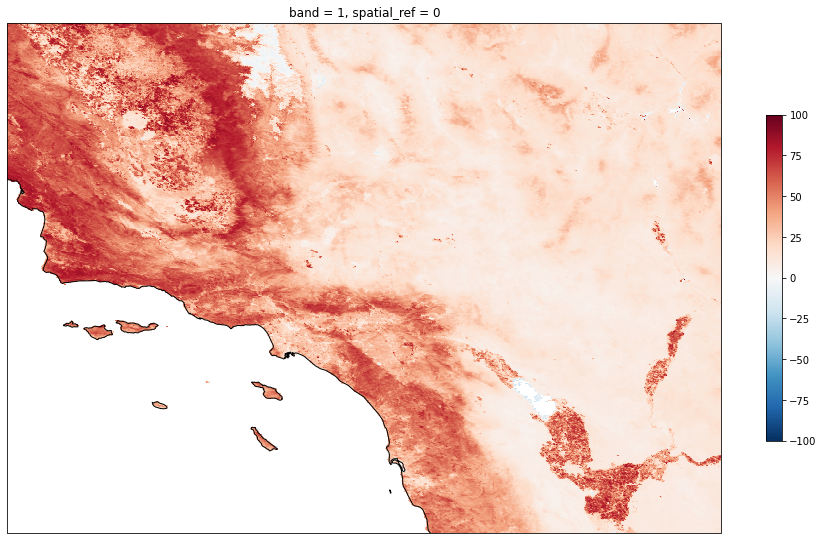

In [88]:
# plot NDVI to visualize
plot_data = modis_ndvi['1 km monthly NDVI']
fig = plt.figure(figsize=(8*2,12*2))
#ax = plt.axes(projection=ccrs.PlateCarree())
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-121, -114, 32, 37], crs=ccrs.PlateCarree())
ax.coastlines()
mesh = plot_data[0].plot.pcolormesh(ax = ax, x='lon' ,y='lat', add_colorbar=False, shading='auto')
fig.colorbar(mesh, shrink=0.25)

In [89]:
modis_ndvi['gvf'] = modis_ndvi['1 km monthly NDVI']
modis_ndvi['gvf'] = modis_ndvi['gvf'].where(modis_ndvi['gvf']>0, other = 0)

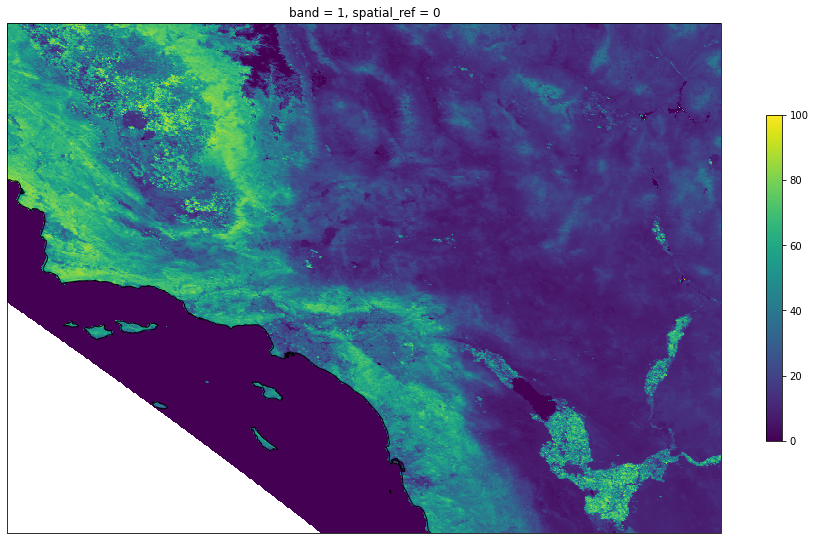

In [90]:
# plot gvf to visualize
plot_data = modis_ndvi['gvf']
fig = plt.figure(figsize=(8*2,12*2))
#ax = plt.axes(projection=ccrs.PlateCarree())
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-121, -114, 32, 37], crs=ccrs.PlateCarree())
ax.coastlines()
mesh = plot_data[0].plot.pcolormesh(ax = ax, x='lon' ,y='lat', add_colorbar=False, shading='auto')
fig.colorbar(mesh, shrink=0.25)

In [83]:
### !!!!!!! IF FIRST TIME REGRIDDING !!!!!!!!!!!! ###
regridder = xe.Regridder(modis_ndvi['gvf'], wrf_ds, 'bilinear', 
                         filename='mod13_to_wrf_regrid_weights.nc')

/Users/josephko/opt/anaconda3/envs/xesmf_env/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [91]:
# regrid to WRF grid
regridder_reuse = xe.Regridder(modis_ndvi['gvf'], wrf_ds,'bilinear', periodic=True, 
                               reuse_weights=True, filename='mod13_to_wrf_regrid_weights.nc')

modis_gvf_out = regridder_reuse(modis_ndvi['gvf'])
modis_gvf_out

# write regridded data as netcdf file
modis_gvf_out.to_netcdf(path = "gvf_regridded_test.nc", mode = 'w', )

/Users/josephko/opt/anaconda3/envs/xesmf_env/lib/python3.9/site-packages/xarray/core/dataarray.py:789: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


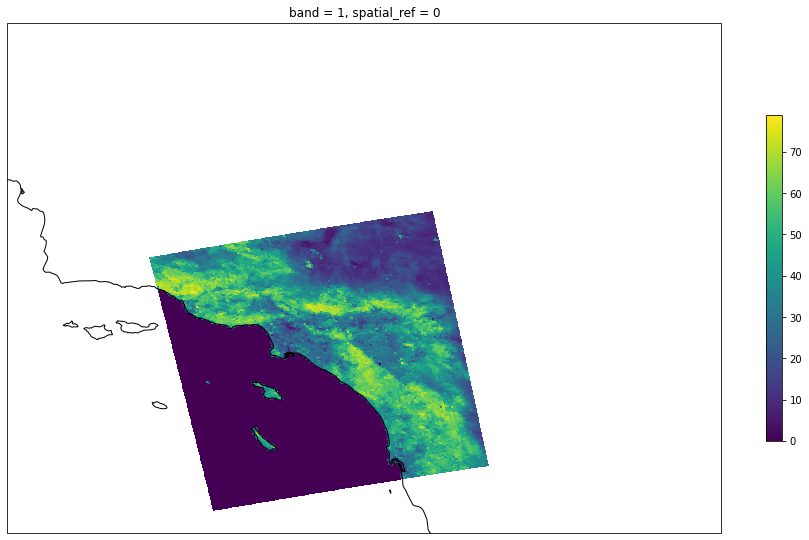

In [92]:
# plot regridded data to visualize
plot_data = modis_gvf_out
fig = plt.figure(figsize=(8*2,12*2))
#ax = plt.axes(projection=ccrs.PlateCarree())
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-121, -114, 32, 37], crs=ccrs.PlateCarree())
ax.coastlines()
mesh = plot_data[0].plot.pcolormesh(ax = ax, x='lon' ,y='lat', add_colorbar=False, shading='auto')
cbar = fig.colorbar(mesh, shrink=0.25)

In [93]:
gvf_default = wrfinput_default['VEGFRA']
gvf_default

<xarray.DataArray 'VEGFRA' (Time: 1, south_north: 141, west_east: 129)>
array([[[ 0.      ,  0.      , ..., 23.376423, 22.606554],
        [ 0.      ,  0.      , ..., 23.383791, 22.573711],
        ...,
        [38.02632 , 37.97043 , ...,  2.00639 ,  1.858368],
        [37.700333, 37.633263, ...,  2.02442 ,  1.88623 ]]], dtype=float32)
Coordinates:
    XLAT     (Time, south_north, west_east) float32 32.23 32.23 ... 35.14 35.14
    XLONG    (Time, south_north, west_east) float32 -119.0 -119.0 ... -116.8
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  VEGETATION FRACTION
    units:        
    stagger:      
    coordinates:  XLONG XLAT XTIME

In [94]:
landmask = wrfinput_default['LANDMASK']
landmask

<xarray.DataArray 'LANDMASK' (Time: 1, south_north: 141, west_east: 129)>
array([[[0., 0., ..., 1., 1.],
        [0., 0., ..., 1., 1.],
        ...,
        [1., 1., ..., 1., 1.],
        [1., 1., ..., 1., 1.]]], dtype=float32)
Coordinates:
    XLAT     (Time, south_north, west_east) float32 32.23 32.23 ... 35.14 35.14
    XLONG    (Time, south_north, west_east) float32 -119.0 -119.0 ... -116.8
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  LAND MASK (1 FOR LAND, 0 FOR WATER)
    units:        
    stagger:      
    coordinates:  XLONG XLAT XTIME

In [95]:
type(modis_ds_out)
modis_gvf_out_mod = modis_gvf_out.where(landmask!=0)
modis_gvf_out_mod = modis_gvf_out_mod.combine_first(gvf_default)
modis_gvf_out_mod

<xarray.DataArray (band: 1, south_north: 141, west_east: 129, Time: 1)>
array([[[[ 0.       ],
         [ 0.       ],
         [ 0.       ],
         ...,
         [39.67527  ],
         [35.22422  ],
         [33.02558  ]],

        [[ 0.       ],
         [ 0.       ],
         [ 0.       ],
         ...,
         [41.388325 ],
         [32.1775   ],
         [37.217266 ]],

        [[ 0.       ],
         [ 0.       ],
         [ 0.       ],
         ...,
...
         ...,
         [ 8.209312 ],
         [ 6.7173157],
         [ 7.9146123]],

        [[49.10571  ],
         [42.713383 ],
         [43.247494 ],
         ...,
         [ 7.9107957],
         [ 6.9161224],
         [ 6.975387 ]],

        [[49.62796  ],
         [51.987957 ],
         [50.17381  ],
         ...,
         [ 8.766649 ],
         [ 7.924988 ],
         [ 7.6383767]]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
    spatial_ref  int64 0
    lon          (south_north, west_east) float32 -119.0 -119.0 ... -116.8
    lat          (south_north, west_east) float32 32.23 32.23 ... 35.14 35.14
    XLAT         (Time, south_north, west_east) float32 32.23 32.23 ... 35.14
    XLONG        (Time, south_north, west_east) float32 -119.0 -119.0 ... -116.8
Dimensions without coordinates: south_north, west_east, Time
Attributes:
    regrid_method:  bilinear

In [96]:
wrfinput_file_path = '/Users/josephko/USC/Research/Remote Sensing/wrf_files/wrfinput_d03_2015run_02_mod.nc'
wrf_input = netCDF4.Dataset(wrfinput_file_path,'r+')
wrf_input['VEGFRA'][:] = modis_gvf_out_mod
wrf_input.close() 